#Demo NeuroEvolution usando Tensorflow-Neuroevolution framework (TFNE) para generar una red ConvNet que pueda aprender a clasificar en base a imágenes

Con TFNE se busca optimizar la topoloǵía de la red (definda a través de conceptos de "blueprints" y "modules") y sus pesos de las conexiones para un cojunto de datos. Para esto último, la red es entrenada con los datos suministrados como si fuera una red normal usando las mismas funciones de Keras / TensorFlow. Por lo tanto  la red generada no es compatible con modelos creados con esa tecnología.

- Nota:  se recomienda ejecutar con GPU para hacer la ejecución más rápido pero pueden producirse errores de sesión por falta de memoria RAM si son demasiadas imágenes o muy grandes.

Fuente TFNE: https://github.com/PaulPauls/Tensorflow-Neuroevolution

Explicación de conceptos en: https://tfne.readthedocs.io/en/latest/codeepneat/codeepneat-overview.html

In [1]:
#@title Cambia a Keras 2 para compatbilidad con la librería TFNE
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

!pip install tf-keras~=2.16

In [2]:
#@title Instalar TFNE
!pip install tfne

###!git clone https://github.com/PaulPauls/Tensorflow-Neuroevolution
###%cd Tensorflow-Neuroevolution
###!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.0/125.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.5/270.5 kB 13.3 MB/s eta 0:00:00


In [3]:
#@title Librerías a usar
from __future__ import annotations
from absl import app, flags, logging

import numpy as np
import tensorflow as tf
import pandas as pd

from matplotlib import pyplot as plt
from PIL import Image

import os
import csv

import tfne
from tfne.environments import BaseEnvironment
from tfne.helper_functions import read_option_from_config

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import ipywidgets as widgets
from ipywidgets import Box, Layout
import random
import math

print("Librerías cargadas")

Librerías cargadas


##Imágenes:

In [5]:
#@title Acceder al Drive

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# directorio local en Google Drive
path = 'gdrive/My Drive/IA/demoML/imagenes/NUMEROS' #@param {type:"string"}
path_entrenamiento = '/train'  #@param {type:"string"}
path_prueba = '/test'  #@param {type:"string"}

imagPath_train = path + path_entrenamiento
imagPath_test = path + path_prueba

Mounted at /content/gdrive


> Para Entrenamiento: 
- Clases cargadas:  10
- Imágenes cargadas:  240
- Ejemplo  7   (32, 32, 3) : 


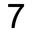



> Para Prueba: 
- Clases cargadas:  10
- Imágenes cargadas:  60
- Ejemplo  6   (32, 32, 3) : 


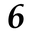

In [6]:
#@title Cargar imágenes

#@markdown ### Parámetros para imágenes:
imagen_ancho =  32#@param {type:"integer"}
imagen_largo =  32#@param {type:"integer"}
imagen_color = True #@param {type:"boolean"}

# tamaño de las imágenes
if imagen_ancho<=10:
  imagen_largo = 10
if imagen_largo<=10:
  imagen_largo = 10
IMAGE_SHAPE = (imagen_ancho, imagen_largo, (3 if imagen_color else 1))

# define función para cargar las imágenes
def cargarImagenes(imagPath):
  classes_ori = []
  images_ori = []

  all_dirs = os.listdir( imagPath )
  for each_dir in all_dirs:

      auxiPath = imagPath + '/' + each_dir
      imagFN  = os.listdir( auxiPath )
      for each_imagFN in imagFN:


            # abre la imagen
            imag = Image.open(auxiPath + "/" + each_imagFN)

            # ajusta el tamaño
            if IMAGE_SHAPE[2]==1:
              tipoImage = 'L'
            else:
              tipoImage = 'RGB'
            imag = imag.convert(tipoImage)
            imag = imag.resize((IMAGE_SHAPE[0], IMAGE_SHAPE[1]), Image.LANCZOS)

            # transforma a un vector de nros
            arImag = np.array(imag)

            # agrega a los vectores
            classes_ori.append( each_dir )
            images_ori.append( arImag )

  return classes_ori, images_ori, tipoImage

# carga las imagenes de entrenamiento
classes_train, images_train, tipoImage_train = cargarImagenes(imagPath_train)
print("> Para Entrenamiento: ")
print("- Clases cargadas: ", len(np.unique(classes_train)))
print("- Imágenes cargadas: ", len(classes_train))

if len(classes_train)>0:
  print("- Ejemplo ", classes_train[0], " ", images_train[0].shape, ": ")
  display( Image.fromarray(images_train[0], tipoImage_train) )

# carga las imagenes de prueba
classes_test, images_test, tipoImage_test = cargarImagenes(imagPath_test)
print("\n\n> Para Prueba: ")
print("- Clases cargadas: ", len(np.unique(classes_test)))
print("- Imágenes cargadas: ", len(images_test))

if len(classes_test)>0:
  print("- Ejemplo ", classes_test[0], " ", images_test[0].shape, ": ")
  display( Image.fromarray(images_test[0], tipoImage_test) )

In [7]:
#@title Ajustar imágenes para reducir el fondo (opcional)

accion_realizar = "-" #@param ["-", "Blur Fondo", "Eliminar Fondo y pasar a Negro", "Eliminar Fondo y pasar a Blanco"]

def cambiarColorNegro(img, nuevoColor=[255, 255, 255]):
    black_pixels = np.where(
        (img[:, :, 0] == 0) &
        (img[:, :, 1] == 0) &
        (img[:, :, 2] == 0)
    )
    img[black_pixels] = nuevoColor
    return img

def blurFondoImagen(im):
  # Convert to the HSV color space
  hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
  # aplica filtro Otsu threshold para obtener máscara
  ret, maskthresh = cv2.threshold(hsv[:,:,0], 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
  # Genera la máscara negada
  maskthresh = 255 - maskthresh
  # We need a to copy the mask 3 times to fit the frames
  maskthresh = np.repeat(maskthresh[:, :, np.newaxis], 3, axis=2)
  #  Create a blurred frame using Gaussian blur
  blurred_frame = cv2.GaussianBlur(im, (25, 25), 0)
  # Combine the original with the blurred frame based on mask
  return np.where(maskthresh == (255, 255, 255), im, blurred_frame)

def reducirFondoImagen(im):
  # aplica filtro Hue
  imhsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
  # aplica filtro Otsu threshold para obtener máscara
  ret, maskthresh = cv2.threshold(imhsv[:,:,0], 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
  # Genera la máscara negada
  maskthresh = 255 - maskthresh
  # aplica la máscara sobre la imagen
  imgfin = cv2.bitwise_and(im, im, mask = maskthresh)
  return imgfin

def procesarImgRedFondo(imgList):
  nList = []
  for im in imgList:
    if accion_realizar == "Blur Fondo":
      # hacer blur del fondo
      imn = blurFondoImagen(im)
    elif accion_realizar == "Eliminar Fondo y pasar a Negro":
      # eliminar fondo y dejar negro
      imn = reducirFondoImagen(im)
    elif accion_realizar == "Eliminar Fondo y pasar a Blanco":
        # cambia fondo negro a casi negro
        # (para que no cambié después)
        imn = cambiarColorNegro(im, [0, 0, 1])
        # eliminar fondo
        imn = reducirFondoImagen(imn)
        # cambiar fondo a blanco
        imn = cambiarColorNegro(imn, [255, 255, 255])
    else:
      print("Acción no definida!")
      break
    nList.append( imn )
  return nList


# degermina si hace algo o no
if accion_realizar != "-":
  # aplica filtros para intentar reducir el fondo de la imagen
  # cambiando las imágenes disponibles
  images_train = procesarImgRedFondo(images_train)
  images_test = procesarImgRedFondo(images_test)

  if len(classes_train)>0:
    print("- Ejemplo Entrenamiento con fondo reducido ", classes_train[0], " ", images_train[0].shape, ": ")
    display( Image.fromarray(images_train[0], tipoImage_train) )

  if len(classes_test)>0:
    print("- Ejemplo Prueba con fondo reducido ", classes_test[0], " ", images_test[0].shape, ": ")
    display( Image.fromarray(images_test[0], tipoImage_test) )

> Para Entrenamiento: 
 - x_train (cant ejemplos, datos entrada):  (240, 32, 32, 3)
 - y_trainEnc (cant):  240
 - y_train (cant):  240


> Para Prueba: 
 - x_test (cant ejemplos, datos entrada):  (60, 32, 32, 3)
 - y_testEnc (cant):  60
 - y_test (cant):  60


> Para Ambos: 
 - dictMapeo:  {'2': 0, '8': 1, '9': 2, '0': 3, '1': 4, '6': 5, '3': 6, '7': 7, '5': 8, '4': 9}
 - clases_map:  ['2', '8', '9', '0', '1', '6', '3', '7', '5', '4']

 - Imagen reconstruida de  7 ( 7  /  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] )


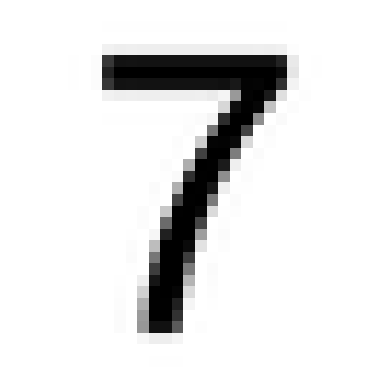

In [8]:
#@title Preparar imágenes para usar en el modelo

# define función auxiliar para mostrar imágenes preparadas
def plot_image(imag):
  if IMAGE_SHAPE[2]==1:
    plt.imshow((imag).reshape(IMAGE_SHAPE[0], IMAGE_SHAPE[1]).astype(np.uint8)) ## *255
    plt.gray()
  else:
    plt.imshow((imag).reshape(IMAGE_SHAPE).astype(np.uint8)) ## *255
  plt.axis("off")

# define función auxiliar para preparar la lista de imágenes a procesar
def prepare_imageList(imagList):
  auxiAr = np.array(imagList) ##.astype('float32') / 255.
  auxiAr = auxiAr.reshape((len(auxiAr), IMAGE_SHAPE[0], IMAGE_SHAPE[1], IMAGE_SHAPE[2]))
  return auxiAr

# define función auxiliar para preparar lista de clases
def prepare_clasesList(classesList, dictMapeo=None):
  if dictMapeo==None:
    # genera diccionario de mapeo
    auxDict = list(set(classesList))
    dictMapeo = dict( zip( auxDict, range(len(auxDict)) ) )
  # realiza el mapeo
  y = []
  for cl in classesList:
      y.append( dictMapeo[cl] )
  # convierte valores numéricos a columnas de vakores binarios (i.e. one hot encoded)
  dummy_y = to_categorical(y)
  # devuelve
  return np.array(y), np.array(dummy_y), dictMapeo

# define vector auxiliar de datos de entrada para usar en el entrenamiento y prueba
x_train = prepare_imageList(images_train)
x_test = prepare_imageList(images_test)

# define vector auxiliar de datos de salida para usar en el entrenamiento y prueba
# también usa esta información para determinar la cantida de neuronas de salida
y_train, y_trainEnc, dictMapeo = prepare_clasesList(classes_train)
y_test, y_testEnc,_ = prepare_clasesList(classes_test, dictMapeo)

# genera diccionario auxiliar para poder convertir de ID de clase a nombre de clase
clases_map = [ x for x,y in dictMapeo.items() ]

print("> Para Entrenamiento: ")
print(" - x_train (cant ejemplos, datos entrada): ", x_train.shape)
print(" - y_trainEnc (cant): ", len(y_trainEnc))
print(" - y_train (cant): ", len(y_train))
print("\n\n> Para Prueba: ")
print(" - x_test (cant ejemplos, datos entrada): ", x_test.shape)
print(" - y_testEnc (cant): ", len(y_testEnc))
print(" - y_test (cant): ", len(y_test))
print("\n\n> Para Ambos: ")
print(" - dictMapeo: ", dictMapeo)
print(" - clases_map: ", clases_map)
if len(y_train)>0:
  print("\n - Imagen reconstruida de ", clases_map[y_train[0]],  "(", y_train[0], " / ", y_trainEnc[0], ")")
  plot_image(x_train[0])

# Modelo:

In [9]:
#@title Crear Archivo Configuración de Parámetros para TFNE
# ver explicación en https://tfne.readthedocs.io/en/latest/codeepneat/codeepneat-config.html

#@markdown Criterio de Paro:
ce_maximo_generaciones_procesar = 5 #@param {type:"integer"}
ce_finalizar_al_encontrar_max_fitness = True #@param {type:"boolean"}
#@markdown Función de Aptitud:
fitness_calc_usando = "Entrenamiento + Validacion" #@param ["Entrenamiento", "Validacion", "Entrenamiento + Validacion"]
fitness_penalizar_x_topologia = False #param {type:"boolean"}
#@markdown Blueprints (topología & optimizador):
ce_cant_poblacion_blueprints =  8#@param {type:"integer"}
#@markdown  Genomas (instancias de RNAs):
ce_cant_genomas_por_blueprint =  10#@param {type:"integer"}
#@markdown Módulos (capas RNA):
ce_cant_poblacion_modulos =  5#@param {type:"integer"}
ce_tipo_generacion_modulos = "Dinamica" #@param ["Basica", "Dinamica", "Fija"]
#@markdown Operadores Genéticos:
ce_max_mutacion = 0.5 #@param {type:"number"}
ce_probab_mutacion = 0.6 #@param {type:"number"}
ce_probab_cruzamiento = 0.4 #@param {type:"number"}
#@markdown Entrenamiento RNA:
rna_cant_epocas_entrenamiento = 50#@param {type:"integer"}
rna_cant_epocas_entrenamiento_incrementa_por_generacion = 25#@param {type:"integer"}

confFileName = './codeepneat_config.cfg'

s = ""
with open(confFileName, 'w') as f:
    s = s + "[EVALUATION]\n"
    s = s + "epochs        = " + str(rna_cant_epocas_entrenamiento) + "\n"
    s = s + "batch_size    = None\n"
    s = s + "preprocessing = None\n"
    if rna_cant_epocas_entrenamiento_incrementa_por_generacion > 0:
      s = s + "increase_epochs_every_n_genomes = " + str(ce_cant_poblacion_blueprints*ce_cant_genomas_por_blueprint) + "\n"
      s = s + "increase_epochs_add_epochs = " + str(rna_cant_epocas_entrenamiento_incrementa_por_generacion) + "\n"
    else:
      s = s + "increase_epochs_every_n_genomes = 0\n"
      s = s + "increase_epochs_add_epochs = 0\n"
    s = s + "\n"
    s = s + "\n"
    s = s + "[FITNESS]\n"
    if fitness_calc_usando == "Entrenamiento":
      s = s + "calc_using_accuracy  = 'E'\n"
    elif fitness_calc_usando == "Validacion":
      s = s + "calc_using_accuracy = 'V'\n"
    else:
      s = s + "calc_using_accuracy = 'E+V'\n"
    s = s + "penalize_based_on_topology  = " + str(fitness_penalizar_x_topologia) + "\n"
    s = s + "\n"
    s = s + "\n"
    s = s + "[POPULATION]\n"
    s = s + "bp_pop_size    = " + str(ce_cant_poblacion_blueprints) + "\n"
    s = s + "mod_pop_size   = " + str(ce_cant_poblacion_modulos) + "\n"
    s = s + "genomes_per_bp = " + str(ce_cant_genomas_por_blueprint ) + "\n"
    s = s + "\n"
    s = s + "\n"
    s = s + "[GENOME]\n"
    s = s + "dtype                = 'float32'\n"
    s = s + "available_modules    = ['Conv2DMaxPool2DDropout']\n"
    s = s + "available_optimizers = ['SGD', 'Adam']\n" # 'SGD',
    s = s + "output_layers        = [{'class_name': 'Flatten', 'config': {}}, \n"
    s = s + "                        {'class_name': 'Dense', 'config': {'units': "+ str(len(clases_map)) + ", 'activation': 'softmax'}}] \n"
    tipo_output_softMax = True
    s = s + "\n"
    s = s + "\n"
    s = s + "[MODULE_SPECIATION]\n"
    if ce_tipo_generacion_modulos == "Dinamica":
      # Dinamica
      s = s + "mod_spec_type            = 'param-distance-dynamic'\n"
      s = s + "mod_spec_species_count   = 4\n"
      s = s + "mod_spec_distance        = 0.3\n"
      s = s + "mod_spec_mod_elitism     = 2\n"
      s = s + "mod_spec_min_offspring   = 1\n"
      s = s + "mod_spec_reprod_thres    = 0.5\n"
      s = s + "mod_spec_max_stagnation  = 15\n"
      s = s + "mod_spec_species_elitism = 2\n"
      s = s + "mod_spec_rebase_repr     = True\n"
      s = s + "mod_spec_reinit_extinct  = False\n"
    elif ce_tipo_generacion_modulos == "Fija":
      # Fija
      s = s + "mod_spec_type            = 'param-distance-fixed'\n"
      s = s + "mod_spec_distance        = 0.3\n"
      s = s + "mod_spec_mod_elitism     = 2\n"
      s = s + "mod_spec_min_offspring   = 1\n"
      s = s + "mod_spec_reprod_thres    = 0.5\n"
      s = s + "mod_spec_max_stagnation  = 10\n"
      s = s + "mod_spec_species_elitism = 2\n"
      s = s + "mod_spec_rebase_repr     = True\n"
      s = s + "mod_spec_reinit_extinct  = False\n"
    else:
      # Basica
      s = s + "mod_spec_type          = 'basic'\n"
      s = s + "mod_spec_mod_elitism   = 4\n"
      s = s + "mod_spec_min_offspring = 1\n"
      s = s + "mod_spec_reprod_thres  = 0.5\n"
    s = s + "\n"
    s = s + "\n"
    s = s + "[MODULE_EVOLUTION]\n"
    s = s + "mod_max_mutation   = " + str(ce_max_mutacion) + "\n"
    s = s + "mod_mutation_prob  = " + str(ce_probab_mutacion) + "\n"
    s = s + "mod_crossover_prob = " + str(ce_probab_cruzamiento) + "\n"
    s = s + "\n"
    s = s + "\n"
    s = s + "[BP_SPECIATION]\n"
    if ce_tipo_generacion_modulos == "Dinamica":
      # Dinamica
      s = s + "bp_spec_type            = 'gene-overlap-dynamic'\n"
      s = s + "bp_spec_species_count   = 3\n"
      s = s + "bp_spec_distance        = 0.3\n"
      s = s + "bp_spec_bp_elitism      = 2\n"
      s = s + "bp_spec_min_offspring   = 1\n"
      s = s + "bp_spec_reprod_thres    = 0.5\n"
      s = s + "bp_spec_max_stagnation  = 15\n"
      s = s + "bp_spec_species_elitism = 2\n"
      s = s + "bp_spec_rebase_repr     = True\n"
      s = s + "bp_spec_reinit_extinct  = True\n"
    elif ce_tipo_generacion_modulos == "Fija":
      # Fija
      s = s + "bp_spec_type            = 'gene-overlap-fixed'\n"
      s = s + "bp_spec_distance        = 0.3\n"
      s = s + "bp_spec_bp_elitism      = 2\n"
      s = s + "bp_spec_min_offspring   = 1\n"
      s = s + "bp_spec_reprod_thres    = 0.5\n"
      s = s + "bp_spec_max_stagnation  = 15\n"
      s = s + "bp_spec_species_elitism = 2\n"
      s = s + "bp_spec_rebase_repr     = True\n"
      s = s + "bp_spec_reinit_extinct  = True\n"
    else:
      # Basica
      s = s + "bp_spec_type          = 'basic'\n"
      s = s + "bp_spec_bp_elitism    = 2\n"
      s = s + "bp_spec_min_offspring = 1\n"
      s = s + "bp_spec_reprod_thres  = 0.5\n"
    s = s + "\n"
    s = s + "\n"
    s = s + "[BP_EVOLUTION]\n"
    if ce_tipo_generacion_modulos == "Dinamica":
      # Dinamica
      s = s + "bp_max_mutation            = 0.3\n"
      s = s + "bp_mutation_add_conn_prob  = 0.2\n"
      s = s + "bp_mutation_add_node_prob  = 0.2\n"
      s = s + "bp_mutation_rem_conn_prob  = 0.05\n"
      s = s + "bp_mutation_rem_node_prob  = 0.05\n"
      s = s + "bp_mutation_node_spec_prob = 0.3\n"
      s = s + "bp_mutation_optimizer_prob = 0.1\n"
      s = s + "bp_crossover_prob          = 0.1\n"
    else:
      # Fija o Basica
      s = s + "bp_max_mutation            = 0.3\n"
      s = s + "bp_mutation_add_conn_prob  = 0.3\n"
      s = s + "bp_mutation_add_node_prob  = 0.3\n"
      s = s + "bp_mutation_rem_conn_prob  = 0.05\n"
      s = s + "bp_mutation_rem_node_prob  = 0.05\n"
      s = s + "bp_mutation_node_spec_prob = 0.1\n"
      s = s + "bp_mutation_optimizer_prob = 0.1\n"
      s = s + "bp_crossover_prob          = 0.1\n"
    s = s + "\n"
    s = s + "\n"
    s = s + "[MODULE_CONV2DMAXPOOL2DDROPOUT]\n"
    s = s + "merge_method  = [{'class_name': 'Concatenate', 'config': {'axis': -1}}, \n"
    s = s + "                 {'class_name': 'Add', 'config': {}}]\n"
    s = s + "filters       = {'min': 8, 'max': 256, 'step': 8, 'stddev': 4}\n"
    s = s + "kernel_size   = [1,2,3]\n"
    s = s + "strides       = [1]\n"
    s = s + "padding       = ['valid', 'same']\n"
    s = s + "activation    = ['linear', 'elu', 'relu']\n"
    s = s + "kernel_init   = ['glorot_uniform']\n"
    s = s + "bias_init     = ['zeros']\n"
    s = s + "max_pool_flag = 0.8\n"
    s = s + "max_pool_size = [1,2,3]\n"
    s = s + "dropout_flag  = 0.5\n"
    s = s + "dropout_rate  = {'min': 0.1, 'max': 0.7, 'step': 0.1, 'stddev': 0.2}\n"
    s = s + "\n"
    s = s + "\n"
    s = s + "[OPTIMIZER_SGD]\n"
    s = s + "learning_rate = {'min': 0.001, 'max': 0.3, 'step': 0.001, 'stddev': 0.02}\n"
    s = s + "momentum      = {'min': 0.3, 'max': 0.7, 'step': 0.1, 'stddev': 0.1}\n"
    s = s + "nesterov      = [True, False] \n"
    s = s + "\n"
    s = s + "\n"
    s = s + "[OPTIMIZER_ADAM]\n"
    s = s + "learning_rate = {'min': 0.0001, 'max': 0.3, 'step': 0.0001, 'stddev': 0.02}\n"
    s = s + "beta_1        = {'min': 0.6, 'max': 1.5, 'step': 0.05, 'stddev': 0.2}\n"
    s = s + "beta_2        = {'min': 0.8, 'max': 1.2, 'step': 0.001, 'stddev': 0.1}\n"
    s = s + "epsilon       = {'min': 1e-8, 'max': 1e-6, 'step': 1e-8, 'stddev': 1e-7}\n"
    s = s + "\n"
    s = s + "\n"

    f.write(s)

# muestra nuevo archivo modificado
%cat {confFileName}


[EVALUATION]
epochs        = 50
batch_size    = None
preprocessing = None
increase_epochs_every_n_genomes = 80
increase_epochs_add_epochs = 25


[FITNESS]
calc_using_accuracy = 'E+V'
penalize_based_on_topology  = False


[POPULATION]
bp_pop_size    = 8
mod_pop_size   = 5
genomes_per_bp = 10


[GENOME]
dtype                = 'float32'
available_modules    = ['Conv2DMaxPool2DDropout']
available_optimizers = ['SGD', 'Adam']
output_layers        = [{'class_name': 'Flatten', 'config': {}}, 
                        {'class_name': 'Dense', 'config': {'units': 10, 'activation': 'softmax'}}] 


[MODULE_SPECIATION]
mod_spec_type            = 'param-distance-dynamic'
mod_spec_species_count   = 4
mod_spec_distance        = 0.3
mod_spec_mod_elitism     = 2
mod_spec_min_offspring   = 1
mod_spec_reprod_thres    = 0.5
mod_spec_max_stagnation  = 15
mod_spec_species_elitism = 2
mod_spec_rebase_repr     = True
mod_spec_reinit_extinct  = False


[MODULE_EVOLUTION]
mod_max_mutation   = 0.5
mod_mutation_pro

In [10]:
#@title Definir clase para el ambiente RNAEnvironment

class RNAEnvironment(BaseEnvironment):
    """
    TFNE compatible environment for the RNA
    """

    def __init__(self, weight_training, data_x, data_y, config=None, verbosity=0, **kwargs):
        """
        Initializes environment by setting up the dataset and processing the supplied config or supplied config
        parameters. The configuration of the environment can either be supplied via a config file or via seperate config
        parameters in the initialization.
        @param weight_training: bool flag, indicating wether evaluation should be weight training or not
        @param config: ConfigParser instance holding an 'Environment' section specifying the required environment
                       parameters for the chosen evaluation method.
        @param verbosity: integer specifying the verbosity of the evaluation
        @param kwargs: Optionally supplied dict of each configuration parameter seperately in order to allow the
                       creation of the evaluation environment without the requirement of a config file.
        """
        # Initialize corresponding input and output mappings
        print("> Preparando el ambiente...")

        # Initialize loss function to evaluate performance on either evaluation method and safe verbosity parameter
        self.accuracy_metric = tf.keras.metrics.Accuracy()
        self.verbosity = verbosity

        # Determine and setup explicit evaluation method in accordance to supplied parameters
        if not weight_training:
              raise NotImplementedError("RNA environment is being set up as non-weight training, though non-weight "
                                      "training evaluation not yet implemented for RNA environment")


        elif config is None and len(kwargs) == 0:
            raise RuntimeError("No se han definido los parámetros para poder realizar la evolución y el entrenamiento de las RNA")

        elif len(kwargs) == 0:
            # Set up environment as weight training and with a supplied config file
            self.eval_genome_fitness = self._eval_genome_fitness_weight_training
            self.epochs = read_option_from_config(config, 'EVALUATION', 'epochs')
            self.batch_size = read_option_from_config(config, 'EVALUATION', 'batch_size')
            self.increase_epochs_every_n_genomes = read_option_from_config(config, 'EVALUATION', 'increase_epochs_every_n_genomes')
            self.increase_epochs_add_epochs = read_option_from_config(config, 'EVALUATION', 'increase_epochs_add_epochs')
            #  parámetros para calculo fitness
            self.calcFitness = read_option_from_config(config, 'FITNESS', 'calc_using_accuracy')
            self.penalFitness = read_option_from_config(config, 'FITNESS', 'penalize_based_on_topology')

        elif config is None:
            # Set up environment as weight training and explicitely supplied parameters
            self.eval_genome_fitness = self._eval_genome_fitness_weight_training
            self.epochs = kwargs['epochs']
            self.batch_size = kwargs['batch_size']
            self.increase_epochs_every_n_genomes = kwargs['increase_epochs_every_n_genomes']
            self.increase_epochs_add_epochs = kwargs['increase_epochs_add_epochs']
            # determina parámetros para calculo fitness
            self.calcFitness = kwargs['fitness_calc_using_accuracy']
            self.penalFitness = kwargs['fitness_penalize_based_on_topology']

        # para problema de clasificación
        print(" Configurado para problema de Clasificación.")
        # Initialize loss function to evaluate performance on either evaluation method
        self.accuracy_metric = tf.keras.metrics.Accuracy()
        # determina neuronas de entrada y salida
        if len(data_x)>0:
          self.cantX = data_x[0].shape
        else:
          self.cantX = None
        self.cantY = data_y.shape[1]

        print(" Definiendo parámetros para cálculo de aptitud: ")
        print("        calcFitness = ", self.calcFitness)
        print("        penalFitness = ", self.penalFitness)

        if self.calcFitness == "E":
            # se toman todos los datos para entrenamiento
            self.x_train, self.y_train, data_x, data_y
            self.x_val, self.y_val = [], []
            self.x_eval, self.y_eval = data_x, data_y
        else:
            # separa al azar usando muestreo al azar del 10%
            # para tomar algunos como datos de validación
            self.x_train, self.x_val, self.y_train, self.y_val = train_test_split(data_x, data_y,
                                                                                    test_size=0.1)
            if self.calcFitness == "V":
              # para calculo de fitness (eval) se usa solamente los de valiadación
              self.x_eval, self.y_eval = self.x_val, self.y_val
            else: #  "E+V":
              # para calculo de fitness (eval) se usan todos (pero los de validación no se usan para entrenar)
              self.x_eval, self.y_eval = data_x, data_y

        print("  Definiendo datos: de los ", len(data_x), "ejemplos de entrenamiento: ")
        print("                      se usan ", len(self.x_train), "ejemplos para entrenar ")
        print("                      se usan ", len(self.x_val), "ejemplos para validar")
        print("                      y ", len(self.x_eval), "ejemplos para calcular fitness.")

        # prepara datos entrenamiento como array
        self.x_train = np.array(self.x_train)
        self.y_train = np.array(self.y_train).reshape(len(self.y_train), self.cantY)
        # prepara datos validación como array
        self.x_val = np.array(self.x_val)
        self.y_val = np.array(self.y_val).reshape(len(self.y_val), self.cantY)
        # prepara datos evaluación
        self.x_eval = np.array(self.x_eval)
        self.y_eval = np.array(self.y_eval).reshape(len(self.y_eval), self.cantY)
        # obtiene id único para evaluar
        self.y_eval = np.argmax(self.y_eval, axis=-1)

        print(" Topología base de la red: ")
        print("\t -Capa Entrada: ", self.cantX,  " / x_train: ",  self.x_train.shape)
        print("\t -Capa Salida: ", self.cantY,  " / y_train " ,  self.y_train.shape)
        print("\n")

        return

    def eval_genome_fitness(self, genome) -> float:
        # TO BE OVERRIDEN
        raise RuntimeError()

    def _apply_penalize_fitness(self, evaluated_fitness, model):
        # penaliza fitness si el modelo es complejo
        maxFit = self.return_MaxFitness()
          # sólo se aplica la penalización
          # si está cercano a alcanzar la aptitud máxima
        if evaluated_fitness >= (maxFit - 11):
          # penaliza aptitud teniendo en cuenta la complejidad de la RNA
          penalLayers = -1.5
          ajusteCantPesos = self.cantX
          for i in range(len(model.layers)):
            l = model.layers[i]
            tipoLay = str(type(l))
            if "Dense" in tipoLay:
              if i > 1:
                # contabiliza en base a la cantidad de pesos de las conexiones
                # nota: no tiene en cuenta los pesos de la capa de entrada ni de salida
                cantPesos = len(l.get_weights()[0])
                penalLayers = penalLayers + (cantPesos / ajusteCantPesos)
            elif "Dropout" in tipoLay:
              penalLayers = penalLayers + 0.8
            elif "Concatenate" in tipoLay:
              penalLayers = penalLayers + 0.9
          if penalLayers > 0:
            evaluated_fitness = evaluated_fitness + 10.0 - (penalLayers / 10.0)
        return evaluated_fitness


    def _calculate_fitness(self, model, penalFitness=False) -> float:
        """
        The genomes fitness is then calculated and returned as
        the percentage of training and/or validation examples classified correctly.
        """
        try:
            # calcula con datos de evaluación (definidas antes)
            if (len(self.x_eval)>0) and (len(self.y_eval)>0):
              self.accuracy_metric.reset_states()
              # ejecuta modelo con datos de evaluación
              resModel = model(self.x_eval)
              # toma ID de clase generada por modelo
              resModel = np.argmax(resModel, axis=-1)
              # calcula métrica
              self.accuracy_metric.update_state(self.y_eval, resModel)
              valAcc = self.accuracy_metric.result().numpy()
              if math.isnan(valAcc):
                evaluated_fitness = 0.0001
              elif valAcc <= 0:
                evaluated_fitness = 0.0002
              else:
                evaluated_fitness = round(valAcc* 100.0, 4)
            else:
              evaluated_fitness = 0.0001
            if penalFitness:
              # ejecuta aplicación de penalización del modelo si corresponde
              evaluated_fitness = self._apply_penalize_fitness(evaluated_fitness, model)
            if math.isnan(evaluated_fitness) or (evaluated_fitness<=0.0):
              return 0.0001
            else:
              return round(evaluated_fitness, 5)
        except Exception as e:
          print("Error calculate_fitness: ", e)
          return 0.0001

    def return_MaxFitness(self) -> float:
      # devuelve valor máximo posible para la aptitud
      valMaxFit = 100.0
      if self.penalFitness:
        valMaxFit = valMaxFit + 10
      return valMaxFit

    def _eval_genome_fitness_weight_training(self, genome) -> float:
        """
        Evaluates the genome's fitness by obtaining the associated Tensorflow model and optimizer,
        compiling them and then training them for the config specified duration.
        @param genome: TFNE compatible genome that is to be evaluated
        @return: genome calculated fitness
        """
        # Get model and optimizer required for compilation
        model = genome.get_model()
        optimizer = genome.get_optimizer()

        # si corresponde incrementa la cantidad de épocas
        gen_id = genome.get_id()
        if gen_id > self.increase_epochs_every_n_genomes:
          cantEpochsIncr = int((gen_id / self.increase_epochs_every_n_genomes) * self.increase_epochs_add_epochs)
          cant_epochs = self.epochs + cantEpochsIncr
          #print("  > ", gen_id, self.epochs, cantEpochsIncr, cant_epochs)
        else:
          cant_epochs = self.epochs

        # Compile and train model
        model.compile(optimizer=optimizer,
                      loss='categorical_crossentropy', metrics=['accuracy'])
        model.fit(x=self.x_train,
                  y=self.y_train,
                  epochs=cant_epochs,
                  batch_size=self.batch_size,
                  verbose=self.verbosity)

        # Evaluate and return its fitness
        return self._calculate_fitness(model, self.penalFitness)

    def _eval_genome_fitness_non_weight_training(self, genome) -> float:
        raise NotImplementedError("Non-Weight training evaluation not yet implemented for Environment")

    def replay_genome(self, genome):
        """
        Replay genome on environment by calculating its fitness and printing it.
        @param genome: TFNE compatible genome that is to be evaluated
        """
        print("> Probando Genome #{}:".format(genome.get_id()))

        # Determine fitness by creating model predictions with test images and then judging the fitness based on the
        # achieved model accuracy.
        model = genome.get_model()
        evaluated_fitness = self._calculate_fitness(model, False)
        print("  Aptitud lograda:\t{}\n".format(evaluated_fitness))

    def duplicate(self) -> RNAEnvironment:
        """
        @return: New instance of the environment with identical parameters
        """
        x = self.x_train.extend(self.x_val)
        y = self.y_train.extend(self.y_val)
        # fuerza forma de y
        y = np.array(y).reshape(len(y), self.cantY)

        if hasattr(self, 'epochs'):
            return RNAEnvironment(True, data_x=x, data_y=y, verbosity=self.verbosity,
                                  epochs=self.epochs, batch_size=self.batch_size)
        else:
            return RNAEnvironment(False, data_x=x, data_y=y, verbosity=self.verbosity)

    def get_input_shape(self) -> (int, int, int):
        """"""
        return self.cantX

    def get_output_shape(self) ->  (int,):
        """"""
        return (self.cantY,)


print("Clase RNAEnvironment definida")

Clase RNAEnvironment definida


In [11]:
#@title Ejecutar NeuroEvolution con TFNE

logging_level = logging.INFO
config_file_path = confFileName # './codeepneat_xor_basic_example_config.cfg'
backup_dir_path = './tfne_state_backups/'
max_generations = ce_maximo_generaciones_procesar

# Set logging, parse config
logging.set_verbosity(logging_level)
config = tfne.parse_configuration(config_file_path)

# Initialize the environment and the specific NE algorithm
environment = RNAEnvironment(weight_training=True,
                             data_x=x_train,
                             data_y=y_trainEnc,
                             config=config,
                             verbosity=logging_level)

print(">  Definiendo configuración:")
ne_algorithm = tfne.algorithms.CoDeepNEAT(config)

# determina si termina por alcanzar la máxima o no
if ce_finalizar_al_encontrar_max_fitness:
  max_fitness = environment.return_MaxFitness()
else:
  max_fitness = None


# Initialize evolution engine and supply config as well as initialized NE algorithm and evaluation environment.
engine = tfne.EvolutionEngine(ne_algorithm=ne_algorithm,
                              environment=environment,
                              backup_dir_path=backup_dir_path,
                              max_generations=max_generations,
                              max_fitness=max_fitness)

# Start training process, returning the best genome when training ends
best_genome = engine.train()
print("\n> Mejor red generada por la evolución:\n")
print(best_genome)
print("\n")

# Graba mejor genotipo y su modelo TF antes del re-entrenamiento
best_genotype_ori_dir = './best_genome_genotype_ori/'
best_model_ori_dir = './best_genome_model_ori/'
best_genome.save_genotype(save_dir_path=best_genotype_ori_dir)
best_genome.save_model(file_path=best_model_ori_dir)

# determina el mejor modelo obtenido
model = tf.keras.models.load_model(best_model_ori_dir)
print("\nModelo recuperado de ", best_model_ori_dir)

print("\n")
model.summary()
print("\n")


> Preparando el ambiente...
Config value for 'EVALUATION/epochs': 50
Config value for 'EVALUATION/batch_size': None
Config value for 'EVALUATION/increase_epochs_every_n_genomes': 80
Config value for 'EVALUATION/increase_epochs_add_epochs': 25
Config value for 'FITNESS/calc_using_accuracy': E+V
Config value for 'FITNESS/penalize_based_on_topology': False
 Configurado para problema de Clasificación.
 Definiendo parámetros para cálculo de aptitud: 
        calcFitness =  E+V
        penalFitness =  False
  Definiendo datos: de los  240 ejemplos de entrenamiento: 
                      se usan  216 ejemplos para entrenar 
                      se usan  24 ejemplos para validar
                      y  240 ejemplos para calcular fitness.
 Topología base de la red: 
	 -Capa Entrada:  (32, 32, 3)  / x_train:  (216, 32, 32, 3)
	 -Capa Salida:  10  / y_train  (216, 10)


>  Definiendo configuración:
Config value for 'POPULATION/bp_pop_size': 8
Config value for 'POPULATION/mod_pop_size': 5
Confi

INFO:absl:Function `_wrapped_model` contains input name(s) resource with unsupported characters which will be renamed to model_dense_biasadd_readvariableop_resource in the SavedModel.
INFO:absl:Found untraced functions such as _jit_compiled_convolution_op while saving (showing 1 of 1). These functions will not be directly callable after loading.
INFO:absl:Sharding callback duration: 33
INFO:absl:Sharding callback duration: 18
INFO:absl:Writing fingerprint to ./best_genome_model_ori/fingerprint.pb



Modelo recuperado de  ./best_genome_model_ori/


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 224)       6272      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 224)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 32, 32, 224)       0         
                                                                 
 flatten (Flatten)           (None, 229376)            0         
                                                                 
 dense (Dense)               (None, 10)                2293770   
           

In [12]:
#@title Evaluar red entrenada con datos de entrenamiento


# función auxiliar para probar el modelo entrenado en detalle
def probarModelo(x, y, clases_map, tipo_output_softMax, umbralClas=50.0, mostrarGradCAM=False, rtdo="TODOS", cantMostrar="TODAS", claseFiltrar=None):

    # determina clase a filtrar
    if (claseFiltrar is None) or (claseFiltrar == "-"):
          clFiltrarID = None
          mostrarImagenes = False
    elif (claseFiltrar == "TODOS"):
          clFiltrarID = None
          mostrarImagenes = True
    else:
          clFiltrarID = dictMapeo[claseFiltrar]
          mostrarImagenes = True
    if umbralClas <= 0.0:
      umbralClas = 0.1
    elif umbralClas >= 100.0:
      umbralClas = 99.0
    else:
      umbralClas = umbralClas/100.0

    # determina tipo de resultado a mostrar
    if rtdo == "Clasificación Incorrecta":
      tipoRes = -1
    elif rtdo == "Clasificación Correcta":
      tipoRes = 1
    else:
      tipoRes = 0

    # determina cantidad a mostrar
    if (cantMostrar == "TODAS"):
      cantMostrar = len(x)
    elif (cantMostrar <= 0):
      cantMostrar = 0
      mostrarImagenes = False

    # procesa las imágenes de prueba con el modelo
    predClass = model.predict(x, verbose=0)

    # lista auxiliar para mostrar
    imgsParaMostrar = []

    # muestra los resultados con las imágenes
    classPreds = []
    classReal = []
    for i in range(len(x)):

        # asigna el nombre de la clase real
        clReal = clases_map[ y[i] ]

        # determina la clase predecida
        if tipo_output_softMax:
            ## determina clase predecida de acuerdo a la que tiene mayor valor
            idclPred = int( np.argmax(predClass[i], axis=0) )
            idclPredRnd = idclPred
        else:
            ## determina clase predecida de acuerdo al umbral de clasificación
            idclPred = predClass[i][0]
            idclPredRnd = int(idclPred)
            if (idclPred - idclPredRnd)>umbralClas and (idclPredRnd+1)<len(clases_map):
                  idclPredRnd = idclPredRnd + 1

        # asigna el nombre de la clase predecida
        if idclPredRnd<0 or idclPredRnd>=len(clases_map):
            clPred = "CLASE " + str(idclPredRnd) + " INVÁLIDA!"
        else:
            clPred = clases_map[ idclPredRnd ]

        # agrega a vevtores auxiliares
        classReal.append( clReal )
        classPreds.append( clPred )
        resClasOK = (clReal==clPred)

        if mostrarImagenes:

          # determina si filtra por clase
          if (clFiltrarID is None) or (clFiltrarID == y[i]):

            # filtra por tipo de resultado
            if (tipoRes==0) or \
              ((tipoRes > 0) and resClasOK) or\
              ((tipoRes < 0) and not(resClasOK)):
                # el titulo par aponer en la imagen
                strTitulo = 'Real: ' + str(clReal) + ' / Modelo: ' + str(clPred)
                if not resClasOK:
                  strTitulo = strTitulo + "!"
                #strTitulo = strTitulo + clPred + ' (' + str( idclPred ) +')'

                # agrega para mostrar
                imgsParaMostrar.append( [strTitulo, x[i] ] )


    # cierra la imagen
    if mostrarImagenes and (cantMostrar>0) and (len(imgsParaMostrar)>0):
      print("\n>Detalle: ")

      if cantMostrar >= len(imgsParaMostrar):
        # muestra todas
        eligeImAlAzar = False
        cantMostrar = len(imgsParaMostrar)
      else:
        # muestra al azar
        eligeImAlAzar = True

      # prepara para mostrar imagenes
      if mostrarGradCAM:
        nCols = 2
        nRows = cantMostrar
        plt.figure(figsize=(5, 3*nRows))
      else:
        nCols = 3
        nRows = cantMostrar // nCols
        if (nRows*nCols) < cantMostrar:
          nRows = nRows + 1
        plt.figure(figsize=(10, 3*nRows))
      posImagen = 1

      for i in range(cantMostrar):
            # elige al azar o no para mostrar
            if eligeImAlAzar:
              posIm = random.randint(1, len(imgsParaMostrar))-1
            else:
              if i >= len(imgsParaMostrar):
                break
              else:
                posIm = i
            # determina datos a mostrar
            im = imgsParaMostrar[posIm][1]
            tit = imgsParaMostrar[posIm][0]

            # muestra la imagen
            ax = plt.subplot(nRows, nCols, posImagen)
            plot_image( im )
            plt.title( tit, fontsize=9 )
            posImagen = posImagen + 1

            # saca elemento de la lista para no elegirlo al azar de nuevo
            if eligeImAlAzar:
              if len(imgsParaMostrar) > posIm:
                imgsParaMostrar.pop( posIm )

      #plt.tight_layout()
      fig = plt.gcf()
      plt.show()
      plt.close(fig)

    # muestra reporte de clasificación
    print("\n Reporte de Clasificación: ")
    print(classification_report(classReal, classPreds, zero_division=0))

    # muestra matriz de confusion
    print('\nMatriz de Confusión ( real / modelo ): ')
    cm = confusion_matrix(classReal, classPreds, labels=clases_map)
    cmtx = pd.DataFrame(
        cm,
        index=['r:{:}'.format(x) for x in clases_map],
        columns=['m:{:}'.format(x) for x in clases_map]
      )
    cmtx.sort_index(axis=0, inplace=True)
    cmtx.sort_index(axis=1, inplace=True)
    print(cmtx)
    print("\n")


# genera toda la interface para evaluar modeo DAE
def crearUI_evaluarModelo(clDefecto, clases, ruidoPorDefecto, funcionCambiaSeleccion):

  # auxiliar para que muestre bien la descripción
  style_3D = {'description_width': 'initial'}
  childrenList = []

  slider_umbral = widgets.FloatSlider(
      value=50,
      min=0,
      max=100.0,
      step=1.0,
      description='Umbral de Clasificación: ',
      disabled=False,
      continuous_update=False,
      orientation='horizontal',
      readout=True,
      style=style_3D,
      readout_format='.1f',
  )
  if not tipo_output_softMax:
    childrenList.append( slider_umbral )

  # prepara combo para filtrar por clase
  seleccion_CLASES = ["-", "TODOS"]
  seleccion_CLASES.extend( clases )
  seleccion_CLASES.sort()
  combo_clase = widgets.Dropdown(
      options = seleccion_CLASES,
      value = clDefecto,
      description = 'Filtrar por clase:',
      style=style_3D,
      disabled = False,
  )
  childrenList.append( combo_clase )

  # prepara combo para filtrar por resultado
  selecc_resutado = [ "TODOS", "Clasificación Incorrecta", "Clasificación Correcta" ]
  combo_resultado = widgets.Dropdown(
      options = selecc_resutado,
      value = selecc_resutado[0],
      description = 'Filtrar por resultado:',
      style=style_3D,
      disabled = False,
  )
  childrenList.append( combo_resultado )

  # prepara combo para filtrar por cantidad
  selecc_cantidad = [ 3 ]
  selecc_cantidad.extend( range(6, 151, 9) )
  selecc_cantidad.append( "TODAS" )
  combo_cantidad = widgets.Dropdown(
      options = selecc_cantidad,
      value = 6,
      description = 'Mostrar N imágenes al azar:',
      style=style_3D,
      disabled = False,
  )
  childrenList.append( combo_cantidad )

  prueba_ui = widgets.GridBox(children=childrenList,
          layout=Layout(width='100%')
        )
  out_prueba = widgets.interactive_output(funcionCambiaSeleccion, {'cant':combo_cantidad, 'rtdo': combo_resultado,'cl':combo_clase, 'umbralClas':slider_umbral})

  return prueba_ui, out_prueba

# función para filtrar por clase
def cambiaSeleccion_clase_evaluar_imEntrenamiento(cant, rtdo, cl, umbralClas):

    # prueba con los datos de entrenamiento
    print("\n\n*** Resultados con datos de Entrenamiento: ")
    probarModelo(x_train, y_train, clases_map, tipo_output_softMax, umbralClas, False, rtdo, cant, cl)

# muestra la interface
ev_entrenamiento_ui, ev_entrenamiento_out = crearUI_evaluarModelo( "-", clases_map, 0.0, cambiaSeleccion_clase_evaluar_imEntrenamiento)
display(ev_entrenamiento_ui, ev_entrenamiento_out)




*** Resultados con datos de Entrenamiento: 

 Reporte de Clasificación: 
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        24
           1       0.96      1.00      0.98        24
           2       1.00      1.00      1.00        24
           3       1.00      1.00      1.00        24
           4       1.00      1.00      1.00        24
           5       1.00      1.00      1.00        24
           6       1.00      1.00      1.00        24
           7       1.00      1.00      1.00        24
           8       0.96      1.00      0.98        24
           9       1.00      1.00      1.00        24

    accuracy                           0.99       240
   macro avg       0.99      0.99      0.99       240
weighted avg       0.99      0.99      0.99       240


Matriz de Confusión ( real / modelo ): 
     m:0  m:1  m:2  m:3  m:4  m:5  m:6  m:7  m:8  m:9
r:0   22    1    0    0    0    0    0    0    1    0
r:1    0   24    

GridBox(children=(Dropdown(description='Filtrar por clase:', options=('-', '0', '1', '2', '3', '4', '5', '6', …

Output()

In [13]:
#@title Evaluar red entrenada con datos de prueba

# función para filtrar por clase
def cambiaSeleccion_clase_evaluar_imEntrenamiento(cant, rtdo, cl, umbralClas):

  # prueba con los datos de prueba
  print("\n\n*** Resultados con datos de Prueba: ")
  probarModelo(x_test, y_test, clases_map, tipo_output_softMax, umbralClas, False, rtdo, cant, cl)

# muestra la interface
ev_entrenamiento_ui, ev_entrenamiento_out = crearUI_evaluarModelo( "-", clases_map, 0.0, cambiaSeleccion_clase_evaluar_imEntrenamiento)
display(ev_entrenamiento_ui, ev_entrenamiento_out)




*** Resultados con datos de Prueba: 

 Reporte de Clasificación: 
              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6
           3       0.86      1.00      0.92         6
           4       1.00      0.83      0.91         6
           5       0.86      1.00      0.92         6
           6       1.00      0.67      0.80         6
           7       0.75      1.00      0.86         6
           8       0.86      1.00      0.92         6
           9       1.00      0.83      0.91         6

    accuracy                           0.92        60
   macro avg       0.93      0.92      0.92        60
weighted avg       0.93      0.92      0.92        60


Matriz de Confusión ( real / modelo ): 
     m:0  m:1  m:2  m:3  m:4  m:5  m:6  m:7  m:8  m:9
r:0    5    0    0    0    0    0    0    0    1    0
r:1    0    6    0    0 

GridBox(children=(Dropdown(description='Filtrar por clase:', options=('-', '0', '1', '2', '3', '4', '5', '6', …

Output()

In [14]:
#@title Guardar Modelo entrenado

guardar_modelo = True #@param{type:"boolean"}
path_modelo = '/content/gdrive/MyDrive/IA/demoCESwarm/NeuroEvolution/modelos/imagenesTFNE'  #@param {type:"string"}

if guardar_modelo:

    # guarda el modelo entrenado
    model.save(path_modelo)
    print("\n-Modelo guardado en ", path_modelo,"\n")

    if ("IMAGE_SHAPE" in locals()) and (IMAGE_SHAPE is not None):
      fn_imageShape = path_modelo+"/IMAGE_SHAPE.txt"
      with open(fn_imageShape, 'w') as f:
        for i in IMAGE_SHAPE:
          f.write(str(i)+"\n")
      print("\n-IMAGE_SHAPE para cargar las imágenes guardado en ", path_modelo,"\n")


    if ("clases_map" in locals()) and (clases_map is not None):
      fn_clases = path_modelo+"/CLASES_MAP.txt"
      with open(fn_clases, 'w') as f:
        for i in range(len(clases_map)):
          f.write(str(i)+":"+str(clases_map[i])+"\n")
      print("\n-CLASES_MAP para mostrar los resultados guardado en ", path_modelo,"\n")

else:
    print("\n-Modelo no guardado.")

INFO:absl:Function `_wrapped_model` contains input name(s) resource with unsupported characters which will be renamed to model_dense_biasadd_readvariableop_resource in the SavedModel.
INFO:absl:Found untraced functions such as _jit_compiled_convolution_op while saving (showing 1 of 1). These functions will not be directly callable after loading.
INFO:absl:Sharding callback duration: 6
INFO:absl:Sharding callback duration: 9
INFO:absl:Writing fingerprint to /content/gdrive/MyDrive/IA/demoCESwarm/NeuroEvolution/modelos/imagenesTFNE/fingerprint.pb



-Modelo guardado en  /content/gdrive/MyDrive/IA/demoCESwarm/NeuroEvolution/modelos/imagenesTFNE 


-IMAGE_SHAPE para cargar las imágenes guardado en  /content/gdrive/MyDrive/IA/demoCESwarm/NeuroEvolution/modelos/imagenesTFNE 


-CLASES_MAP para mostrar los resultados guardado en  /content/gdrive/MyDrive/IA/demoCESwarm/NeuroEvolution/modelos/imagenesTFNE 

